[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/pymc_sdss_2024/blob/master/notebooks/Section5-Model_Checking.ipynb)

# MCMC Output Processing and Model Checking with ArviZ

ArviZ is a Python package for exploratory analysis of Bayesian models. It includes functions for posterior analysis, model checking, comparison and diagnostics. ArviZ is designed to work with output from a wide range of Bayesian inference libraries, including PyMC, emcee, Stan, Pyro, and TensorFlow Probability.

ArviZ is built on top of the popular libraries xarray and matplotlib. It is also built with the same design principles as PyMC, so if you are familiar with PyMC, you will find ArviZ easy to use.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
import scipy.stats as st
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import warnings
warnings.simplefilter("ignore")

RANDOM_SEED = 20090425

### Example: Effect of coaching on SAT scores

This example was taken from Gelman *et al.* (2013):

> A study was performed for the Educational Testing Service to analyze the effects of special coaching programs on test scores. Separate randomized experiments were performed to estimate the effects of coaching programs for the SAT-V (Scholastic Aptitude Test- Verbal) in each of eight high schools. The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be successful at increasing SAT scores. Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.

We are given the estimated coaching effects (`y`) and their sampling variances (`s`). The estimates were obtained by independent experiments, with relatively large sample sizes (over thirty students in each school), so you it can be assumed that they have approximately normal sampling distributions with known variances variances.

In [2]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
s = np.array([15, 10, 16, 11, 9, 11, 10, 18])
schools = np.array(
    [
        "Choate",
        "Deerfield",
        "Phillips Andover",
        "Phillips Exeter",
        "Hotchkiss",
        "Lawrenceville",
        "St. Paul's",
        "Mt. Hermon",
    ]
)

with pm.Model(coords={'school': schools}) as schools:
    
    mu = pm.Normal("mu", 0, sigma=1e6)
    tau = pm.HalfCauchy("tau", 5)

    theta = pm.Normal("theta", mu, sigma=tau, dims='school')

    obs = pm.Normal("obs", theta, sigma=s, observed=y)

In [3]:
with schools:
    # Model fitting
    schools_trace = pm.sample(500, tune=0, random_seed=RANDOM_SEED)
    # Posterior predictive sampling
    pm.sample_posterior_predictive(schools_trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Output()

Sampling 4 chains for 0 tune and 500 draw iterations (0 + 2_000 draws total) took 3 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [obs]


Output()

After running an MCMC simulation, `sample` returns an `arviz.InferenceData` object containing the samples for all the stochastic and named deterministic random variables. 

Data corresponding to each type of sampling is available as an `InferenceData` attribute.

In [4]:
post = schools_trace.posterior
post

<xarray.Dataset> Size: 165kB
Dimensions:  (chain: 4, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
Data variables:
    mu       (chain, draw) float64 16kB 0.4021 -0.7953 -0.6527 ... 12.78 7.753
    tau      (chain, draw) float64 16kB 0.5 0.6114 0.9921 ... 4.872 8.44 8.245
    theta    (chain, draw, school) float64 128kB 0.287 -0.724 ... 9.072 23.46
Attributes:
    created_at:                 2024-06-04T19:44:39.378520+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1+17.g508a1341f.dirty
    sampling_time:              2.84002947807312
    tuning_steps:               0

Arbitary values can be added to an `InferenceData` object using the dictionary assignment syntax.

In [5]:
post["log_tau"] = np.log(post["tau"])
schools_trace.posterior

<xarray.Dataset> Size: 181kB
Dimensions:  (chain: 4, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
Data variables:
    mu       (chain, draw) float64 16kB 0.4021 -0.7953 -0.6527 ... 12.78 7.753
    tau      (chain, draw) float64 16kB 0.5 0.6114 0.9921 ... 4.872 8.44 8.245
    theta    (chain, draw, school) float64 128kB 0.287 -0.724 ... 9.072 23.46
    log_tau  (chain, draw) float64 16kB -0.6932 -0.492 -0.007915 ... 2.133 2.11
Attributes:
    created_at:                 2024-06-04T19:44:39.378520+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1+17.g508a1341f.dirty
    sampling_time:              2.84002947807312
    tuning_steps:               0

### Combining chains and draws

`arviz.extract` is a convenience function aimed at taking care of the most common subsetting operations with MCMC samples. It can:
- Combine chains and draws
- Return a subset of variables (with optional filtering with regular expressions or string matching)
- Return a subset of samples. Moreover by default it returns a random subset to prevent getting non-representative samples due to bad mixing.
- Access any group

In [6]:
az.extract(post)


<xarray.Dataset> Size: 225kB
Dimensions:  (sample: 2000, school: 8)
Coordinates:
  * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 16kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    mu       (sample) float64 16kB 0.4021 -0.7953 -0.6527 ... 8.684 12.78 7.753
    tau      (sample) float64 16kB 0.5 0.6114 0.9921 1.364 ... 4.872 8.44 8.245
    theta    (school, sample) float64 128kB 0.287 -0.5458 -3.06 ... -0.206 23.46
    log_tau  (sample) float64 16kB -0.6932 -0.492 -0.007915 ... 1.583 2.133 2.11
Attributes:
    created_at:                 2024-06-04T19:44:39.378520+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1+17.g508a1341f.dirty
    sampling_time:              2.84002947807312
    tuning_steps:               0

If we only want a subset of the samples, we can use `extract` to resample them.

> Use a random seed to get the same subset from multiple groups: `az.extract(idata, num_samples=100, rng=3)` and `az.extract(idata, group="log_likelihood", num_samples=100, rng=3)` will continue to have matching samples

In [7]:
az.extract(post, num_samples=100)

<xarray.Dataset> Size: 12kB
Dimensions:  (sample: 100, school: 8)
Coordinates:
  * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
  * sample   (sample) object 800B MultiIndex
  * chain    (sample) int64 800B 2 3 0 3 1 2 2 2 0 2 3 ... 3 1 1 2 0 3 1 1 0 2 0
  * draw     (sample) int64 800B 32 95 267 65 152 289 ... 67 462 257 370 84 122
Data variables:
    mu       (sample) float64 800B 12.86 2.31 6.1 7.301 ... 2.815 12.69 6.645
    tau      (sample) float64 800B 2.493 6.368 4.63 ... 0.8773 0.9836 5.018
    theta    (school, sample) float64 6kB 9.915 8.719 15.76 ... 12.69 13.18
    log_tau  (sample) float64 800B 0.9133 1.851 1.532 ... -0.1309 -0.01654 1.613
Attributes:
    created_at:                 2024-06-04T19:44:39.378520+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1+17.g508a1341f.dirty
    sampling_time:              2.84002947807312
    tuning_steps:               0

Sometimes we want to strip away the `InferenceData` overhead and access the raw values. We can extract values as a NumPy array using the `values` attribute.

In [9]:
az.extract(post).mu.to_numpy()


array([ 0.40213853, -0.79529646, -0.65267974, ...,  8.68406408,
       12.7776012 ,  7.75295396])

Computing the mean and other summary statistics can be perfomed directly. By default, this will summarize across all dimensions.

In [10]:
post.mean()

<xarray.Dataset> Size: 32B
Dimensions:  ()
Data variables:
    mu       float64 8B 7.473
    tau      float64 8B 3.633
    theta    float64 8B 7.508
    log_tau  float64 8B 0.9249

Often, however, we may just want to summarize across chains and draws, especially for multivariate quantities.

In [11]:
post.theta.mean(dim=["chain", "draw"])

<xarray.DataArray 'theta' (school: 8)> Size: 64B
array([8.99110722, 7.59133838, 6.73598678, 7.39766979, 6.08198174,
       6.68709607, 8.93806972, 7.64126691])
Coordinates:
  * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'

Finally, subsets of the output can be extracted using the `sel` method. For example, let's look at the posterior distribution of the coaching effects for just one school:

In [12]:
post["theta"].sel(school="Choate")

<xarray.DataArray 'theta' (chain: 4, draw: 500)> Size: 16kB
array([[ 0.28696169, -0.54579256, -3.05983539, ...,  1.40992952,
         2.30047978,  2.30372069],
       [-0.535697  , -0.63082634,  5.97481964, ...,  3.50714312,
        -5.00133937, 20.53738819],
       [-0.13547369,  0.1257461 , -0.25223395, ...,  7.19844649,
         9.00192116, 10.50932477],
       [ 1.31333571,  1.42533921,  1.76577162, ...,  9.10090646,
        15.51144681,  8.79152351]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    school   <U16 64B 'Choate'

Or, we can extract a single chain, for all variables:

In [13]:
post.sel(chain=0)

<xarray.Dataset> Size: 49kB
Dimensions:  (draw: 500, school: 8)
Coordinates:
    chain    int64 8B 0
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
Data variables:
    mu       (draw) float64 4kB 0.4021 -0.7953 -0.6527 ... 2.199 2.134 2.439
    tau      (draw) float64 4kB 0.5 0.6114 0.9921 1.364 ... 0.4936 0.3923 0.4197
    theta    (draw, school) float64 32kB 0.287 -0.724 1.296 ... 2.471 2.774
    log_tau  (draw) float64 4kB -0.6932 -0.492 -0.007915 ... -0.9358 -0.8681
Attributes:
    created_at:                 2024-06-04T19:44:39.378520+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1+17.g508a1341f.dirty
    sampling_time:              2.84002947807312
    tuning_steps:               0

## Model Checking

The final step in Bayesian computation is model checking, in order to ensure that inferences derived from your sample are valid

There are **two components** to model checking:

1. Convergence diagnostics
2. Goodness of fit

Convergence diagnostics are intended to detect **lack of convergence** in the Markov chain Monte Carlo sample; it is used to ensure that you have not halted your sampling too early. However, a converged model is not guaranteed to be a good model. 

The second component of model checking, goodness of fit, is used to check the **internal validity** of the model, by comparing predictions from the model to the data used to fit the model. 

## Convergence Diagnostics

Valid inferences from sequences of MCMC samples are based on the
assumption that the samples are derived from the true posterior
distribution of interest. Theory guarantees this condition as the number
of iterations approaches infinity. It is important, therefore, to
determine the **minimum number of samples** required to ensure a reasonable
approximation to the target posterior density. Unfortunately, no
universal threshold exists across all problems, so convergence must be
assessed independently each time MCMC estimation is performed. The
procedures for verifying convergence are collectively known as
*convergence diagnostics*.

There are a handful of easy-to-use methods for checking convergence. Since you cannot prove convergence, but only show lack of convergence, there is no single method that is foolproof. So, its best to look at a suite of diagnostics together. 

We will cover the canonical set of checks:

- Sampler statistics
- Variable plotting
- Divergences
- R-hat
- Effective Sample Size


## Sampler Statistics

When checking for convergence or when debugging a badly behaving sampler, it is often helpful to take a closer look at what the sampler is doing. For this purpose some samplers export statistics for each generated sample.

NUTS provides several metrics related to the performance of the sampler.

In [14]:
schools_trace.sample_stats

<xarray.Dataset> Size: 248kB
Dimensions:                (chain: 4, draw: 500)
Coordinates:
  * chain                  (chain) int64 32B 0 1 2 3
  * draw                   (draw) int64 4kB 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables: (12/17)
    acceptance_rate        (chain, draw) float64 16kB 0.9542 1.0 ... 0.9844
    diverging              (chain, draw) bool 2kB False False ... False False
    energy                 (chain, draw) float64 16kB 66.51 63.35 ... 77.89
    energy_error           (chain, draw) float64 16kB -0.4363 ... -0.07977
    index_in_trajectory    (chain, draw) int64 16kB 6 -23 -10 63 ... -79 -60 -93
    largest_eigval         (chain, draw) float64 16kB nan nan nan ... nan nan
    ...                     ...
    process_time_diff      (chain, draw) float64 16kB 0.02385 ... 0.01006
    reached_max_treedepth  (chain, draw) bool 2kB False False ... False False
    smallest_eigval        (chain, draw) float64 16kB nan nan nan ... nan nan
    step_size              (chain, draw) float64 16kB 0.1406 0.1406 ... 0.1406
    step_size_bar          (chain, draw) float64 16kB 0.1406 0.1406 ... 0.1406
    tree_depth             (chain, draw) int64 16kB 4 5 5 6 5 5 ... 8 7 7 7 7 8
Attributes:
    created_at:                 2024-06-04T19:44:39.386804+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1+17.g508a1341f.dirty
    sampling_time:              2.84002947807312
    tuning_steps:               0

The sample statistics variables are defined as follows:

- `process_time_diff`: The time it took to draw the sample, as defined by the python standard library time.process_time. This counts all the CPU time, including worker processes in BLAS and OpenMP.

- `step_size`: The current integration step size.

- `diverging`: (boolean) Indicates the presence of leapfrog transitions with large energy deviation from starting and subsequent termination of the trajectory. “large” is defined as `max_energy_error` going over a threshold.

- `lp`: The joint log posterior density for the model (up to an additive constant).

- `energy`: The value of the Hamiltonian energy for the accepted proposal (up to an additive constant).

- `energy_error`: The difference in the Hamiltonian energy between the initial point and the accepted proposal.

- `perf_counter_diff`: The time it took to draw the sample, as defined by the python standard library time.perf_counter (wall time).

- `perf_counter_start`: The value of time.perf_counter at the beginning of the computation of the draw.

- `n_steps`: The number of leapfrog steps computed. It is related to `tree_depth` with `n_steps <= 2^tree_dept`.

- `max_energy_error`: The maximum absolute difference in Hamiltonian energy between the initial point and all possible samples in the proposed tree.

- `acceptance_rate`: The average acceptance probabilities of all possible samples in the proposed tree.

- `step_size_bar`: The current best known step-size. After the tuning samples, the step size is set to this value. This should converge during tuning.

- `tree_depth`: The number of tree doublings in the balanced binary tree.

It can be helpful to plot some of these variables, rather than staring at vectors of numbers!

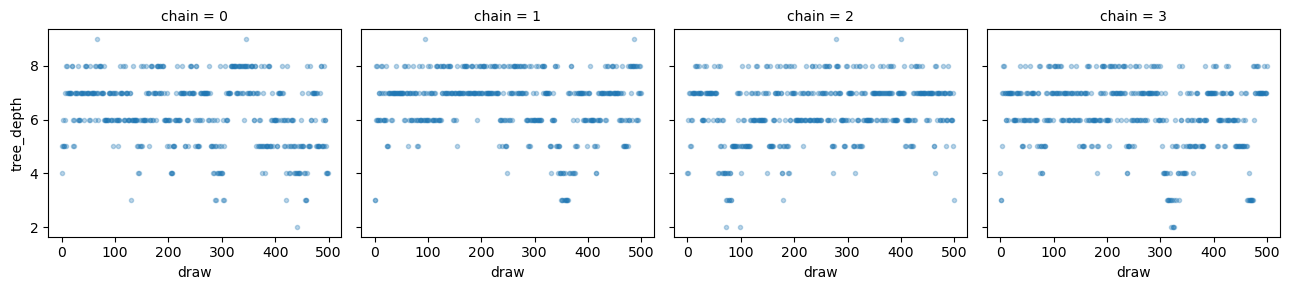

In [15]:
schools_trace.sample_stats["tree_depth"].plot(col="chain", ls="none", marker=".", alpha=0.3);

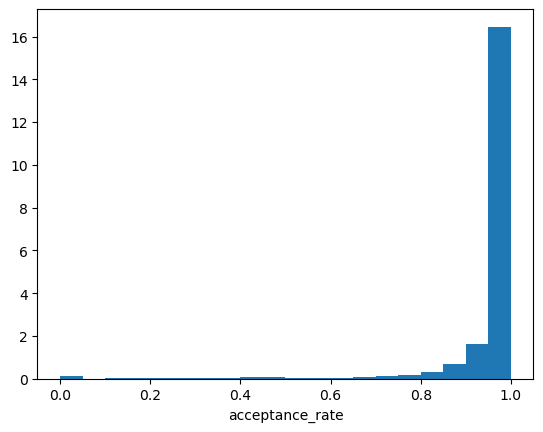

In [16]:
schools_trace.sample_stats["acceptance_rate"].plot.hist(bins=20, density=True);

## Output Visualization with ArviZ

[ArviZ](https://arviz-devs.github.io/arviz/) is a Python package for exploratory analysis of Bayesian models. It includes functions for posterior analysis, model checking, comparison and diagnostics and is designed to work with a range of Bayesian inference libraries (not just PyMC).

ArviZ is built on top of the popular libraries xarray and matplotlib. It is also built with the same design principles as PyMC, so if you are familiar with PyMC, you will find ArviZ easy to use.

ArviZ accomodates many different input data types, even simple NumPy arrays.

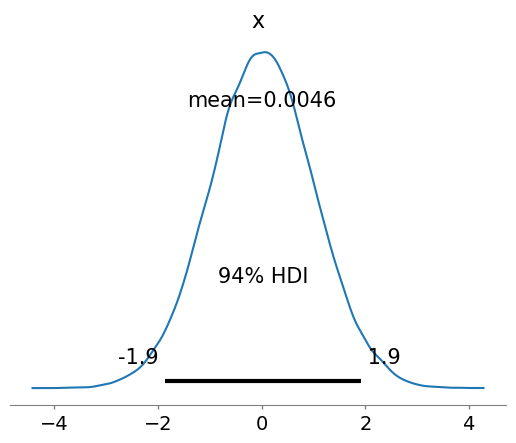

In [17]:
az.plot_posterior(np.random.randn(100_000));

Plotting a dictionary of arrays, ArviZ will interpret each key as the name of a different random variable. Each row of an array is treated as an independent series of draws from the variable, called a _chain_. Below, we have 10 chains of 50 draws, each for four different distributions.

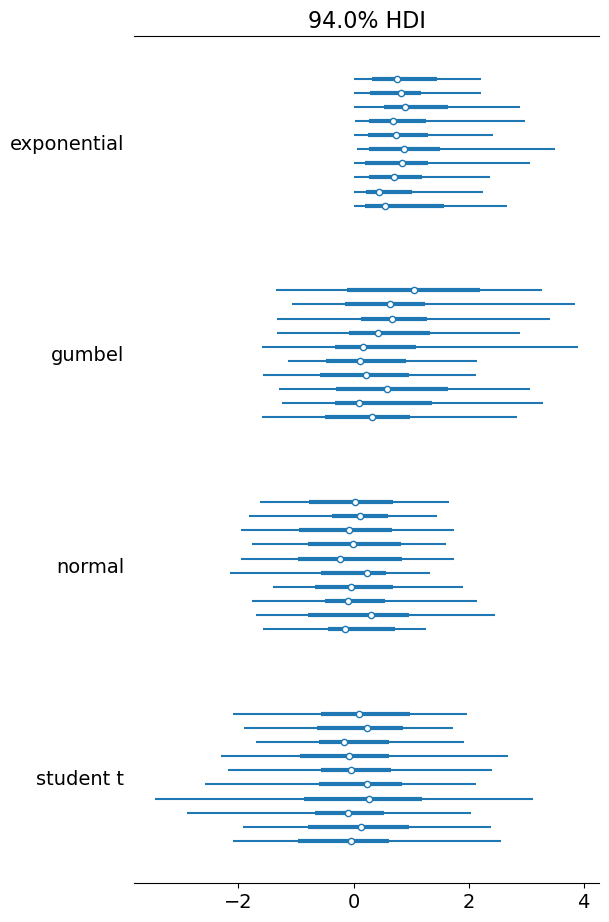

In [18]:
size = (10, 50)
az.plot_forest(
    {
        "normal": np.random.randn(*size),
        "gumbel": np.random.gumbel(size=size),
        "student t": np.random.standard_t(df=6, size=size),
        "exponential": np.random.exponential(size=size),
    }, 
);

## Traceplot 

Perhaps the most-used ArviZ plot is the traceplot, obtained via the `plot_trace` function. This is a simple plot that is a good quick check to make sure nothing is obviously wrong, and is usually the first diagnostic step you will take. You've seen these already: just the time series of samples for an individual variable.



The `plot_trace` function from ArViZ by default generates a kernel density plot and a trace plot, with a different color for each chain of the simulation.

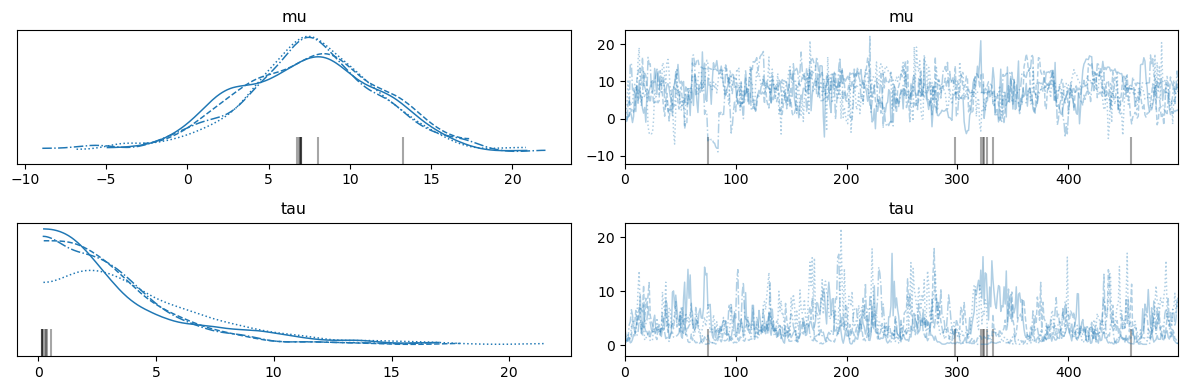

In [19]:
az.plot_trace(schools_trace, var_names=['mu', 'tau']);
plt.tight_layout();

This sample is deliberately inadequate. Looking at the trace plot, the problems should be apparent.

Can you identify the issues, based on what you learned in the previous section?

### Exercise: Take a quiz!

[See how well you can identify sampling problems by looking at their traceplots](https://canyon289.github.io/bayesian-model-evaluation/lessonplans/mcmc_basics/#/14)

The slides will show you a trace, and you have to guess whether the sampling is from one of:

- MCMC with step size too small
- MCMC with step size too large
- MCMC with adequate step size
- Independent samples from distribution

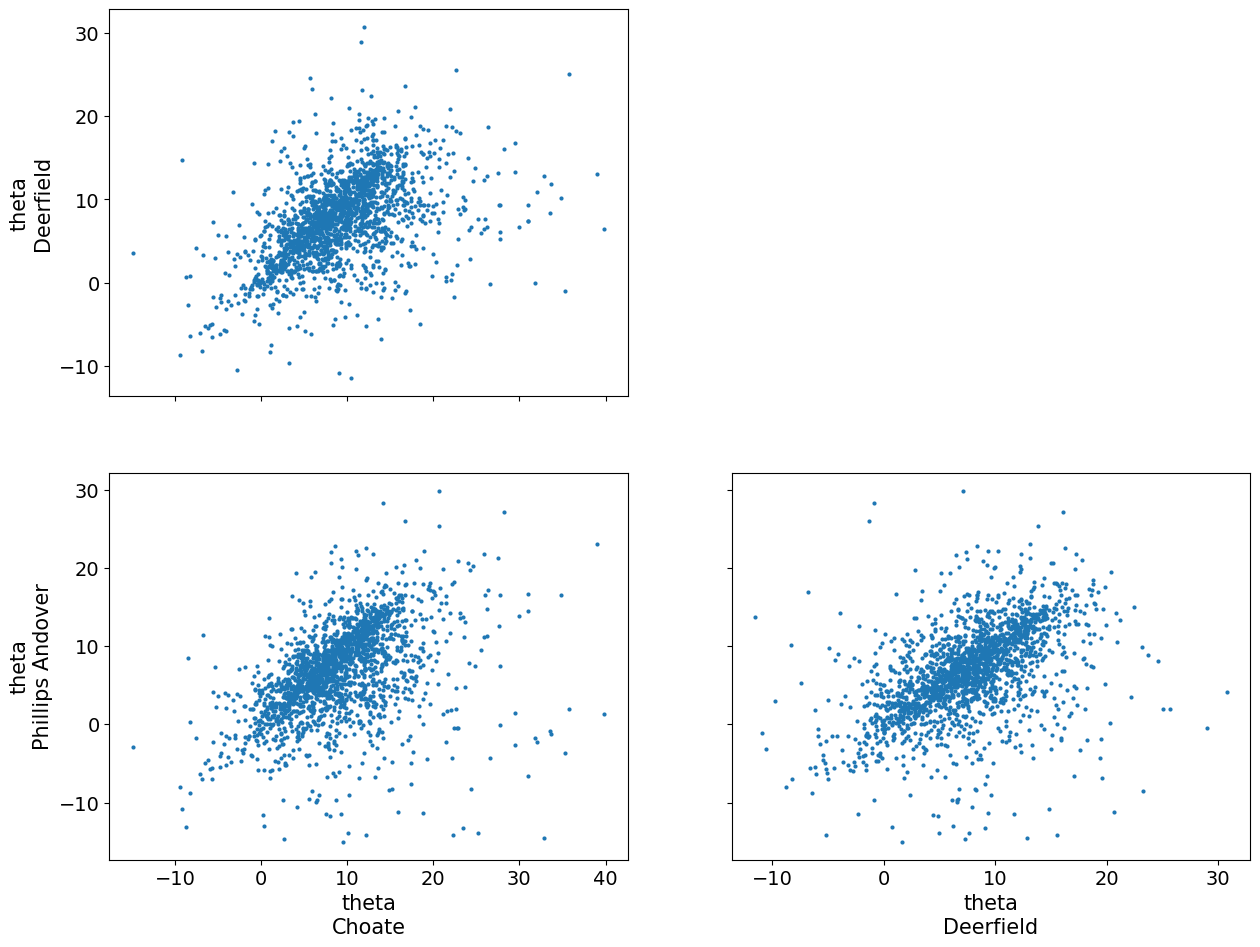

In [20]:
az.plot_pair(
    schools_trace.posterior.theta,
    coords={"school": ["Choate", "Deerfield", "Phillips Andover"]},
);

## Divergences

As we have seen, Hamiltonian Monte Carlo (and NUTS) performs numerical integration in order to explore the posterior distribution of a model. When the integration goes wrong, it can go dramatically wrong. 

For example, here are some Hamiltonian trajectories on the distribution of two correlated variables. Can you spot the divergent path?

![divering HMC](images/diverging_hmc.png)

The reason that this happens is that there may be parts of the posterior which are **hard to explore** for geometric reasons. Two ways of solving divergences are

1. **Set a higher "target accept" rate**: Similarly (but not the same) as for Metropolis-Hastings, larger integrator steps lead to lower acceptance rates. A higher `target_accept` will generally cause a smaller step size, and more accurate integration.
2. **Reparametrize**: If you can write your model in a different way that has the same joint probability density, you might do thpt. A lot of work is being done to automate this, since it requires careful work, and one goal of a probabilistic programming language is to iterate quickly. See [Hoffmann, Johnson, Tran (2018)](https://arxiv.org/abs/1811.11926), [Gorinova, Moore, Hoffmann (2019)](https://arxiv.org/abs/1906.03028).

You should be wary of a trace that contains many divergences (particularly those clustered in particular regions of the parameter space), and give thought to how to fix them.

### Divergence example

The trajectories above are from a famous example of a difficult geometry: Neal's funnel. It is problematic because the geometry is very different in some regions of the state space relative to others. Specifically, for hierarchical models, as the scale parameter changes in size so do the values of the parameters it is constraining. When the variance is close to zero, the parameter space is very constrained relative to the majority of the support.

In [21]:
def neals_funnel(dims=1):
    with pm.Model() as funnel:
        v = pm.Normal('v', 0, 3)
        x_vec = pm.MvNormal('x_vec', mu=pt.zeros(dims), cov=2 * pt.exp(v) * pt.eye(dims), shape=dims)
    return funnel

with neals_funnel():
    funnel_trace = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, x_vec]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 577 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


PyMC provides us feedback on divergences, including a count and a recommendation on how to address them. 

In [22]:
funnel_trace

Inference data with groups:
	> posterior
	> sample_stats

In [23]:
diverging_ind = funnel_trace.sample_stats['diverging'].values[0].nonzero()
diverging_ind

(array([ 23,  30,  31,  35,  36,  39,  45,  47,  48,  50,  51,  57,  59,
         62,  67,  71,  72,  73,  74,  75,  76,  81,  87,  90,  92,  99,
        112, 114, 115, 117, 118, 119, 120, 124, 125, 126, 128, 129, 133,
        135, 136, 142, 149, 153, 154, 155, 159, 161, 164, 167, 215, 221,
        228, 231, 237, 259, 269, 272, 300, 301, 302, 303, 321, 336, 337,
        338, 355, 363, 374, 382, 388, 389, 422, 423, 425, 426, 428, 429,
        434, 437, 446, 449, 473, 475, 485, 488, 500, 503, 504, 505, 507,
        508, 511, 513, 514, 516, 517, 518, 522, 537, 545, 549, 561, 570,
        616, 622, 623, 632, 657, 696, 698, 709, 711, 736, 738, 751, 758,
        760, 761, 762, 771, 772, 773, 774, 776, 780, 789, 794, 798, 799,
        801, 811, 814, 815, 816, 817, 819, 820, 822, 829, 858, 864, 908,
        909, 911, 959, 984, 985, 987]),)

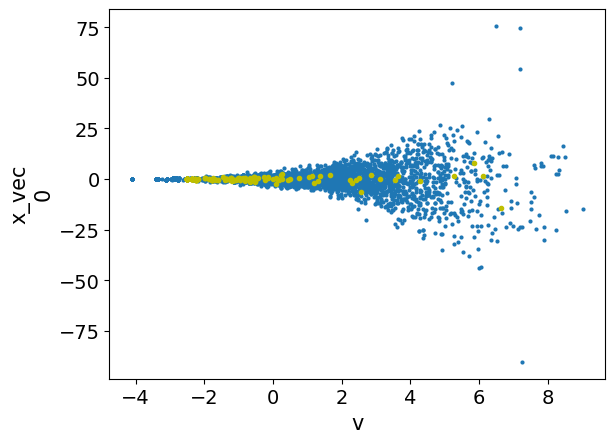

In [24]:
ax = az.plot_pair(funnel_trace)
ax.plot(funnel_trace.posterior['v'].sel(chain=0).values[diverging_ind], funnel_trace.posterior['x_vec'].sel(chain=0).values[diverging_ind].squeeze(), 'y.');

The `plot_parallel` function in the ArViZ library is a convenient way to identify patterns in divergent traces:

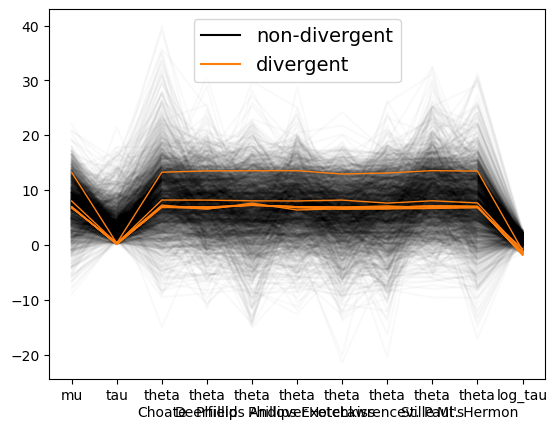

In [25]:
az.plot_parallel(schools_trace);

We have already seen this phenomenon in the radon example from the previous section section. Let's re-run the random-slopes model, which has a hierarchical model for the basement effect or radon measurements.

In [26]:
# Import radon data
radon_data = pl.read_csv('../data/radon.csv')

counties = radon_data["county"].unique()
n_counties = counties.shape[0]
county, log_radon, floor_measure, Uppm = radon_data[
    ["county_code", "log_radon", "floor", "Uppm"]].to_numpy().T
log_uranium = np.log(Uppm)
county = county.astype(int)
county_lookup = dict(zip(counties, np.arange(n_counties)))

In [30]:
with pm.Model() as varying_slope:
    
    # Priors
    mu_b = pm.Normal('mu_b', mu=0., sigma=10)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # Common intercepts
    a = pm.Normal('a', mu=0., sigma=10)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)
    
    # Model error
    sigma_y = pm.HalfCauchy('sigma_y',5)
    
    # Expected value
    y_hat = a + b[county] * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)

In [31]:
with varying_slope:
    varying_slope_trace = pm.sample(cores=2, tune=100, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_b, sigma_b, a, b, sigma_y]


Output()

Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 5 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


If we plot the locations of the divergences, we can see that they are located near the tip of the funnel.

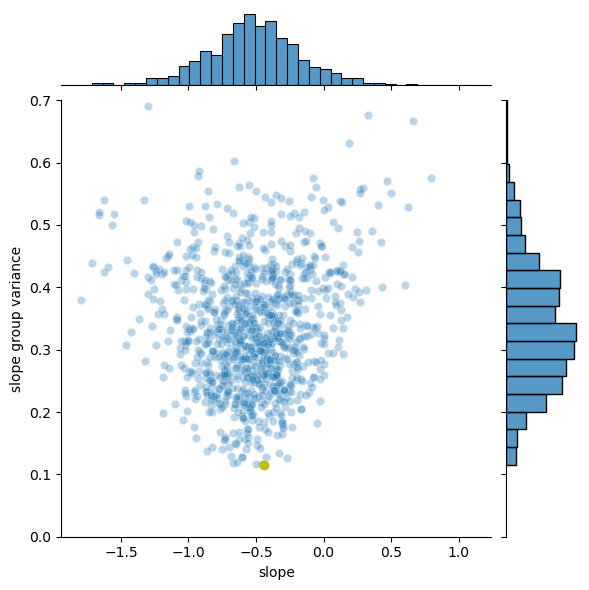

In [32]:
x = pl.Series('slope', varying_slope_trace.posterior['b'].sel(chain=0)[:, 10].to_numpy())
y = pl.Series('slope group variance', varying_slope_trace.posterior['sigma_b'].sel(chain=0).to_numpy())
diverging = varying_slope_trace.sample_stats['diverging'].sel(chain=0)

jp = sns.jointplot(x=x, y=y, ylim=(0, .7), alpha=0.3)
jp.ax_joint.plot(x.to_numpy()[diverging], y.to_numpy()[diverging], 'yo');

When the group variance is small, this implies that the individual random slopes are themselves close to the group mean. In itself, this is not a problem, since this is the behavior we expect. However, if the sampler is tuned for the wider (unconstrained) part of the parameter space, it has trouble in the areas of higher curvature. The consequence of this is that the neighborhood close to the lower bound of $\sigma_b$ is sampled poorly; indeed, in our chain it is not sampled at all below 0.1. The result of this will be biased inference.

Now that we've spotted the problem, what can we do about it? The best way to deal with this issue is to reparameterize our model.

### Solution: Non-centered Parameterization

As we saw in the previous section, this is due to the use of a **centered** parameterization of the slope random effect. That is, the individual county effects are distributed around a county mean, with a spread controlled by the hierarchical standard deviation parameter. 

Here is the DAG of this centered model:

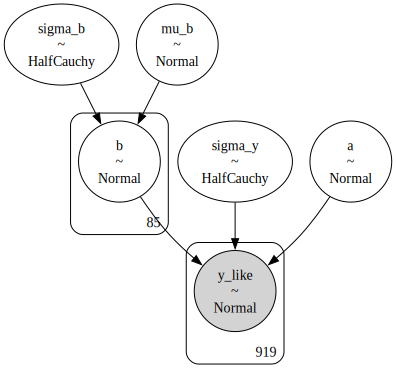

In [33]:
pm.model_to_graphviz(varying_slope)

We can remove the issue with sampling geometry by **reparameterizing** our model:

In [34]:
with pm.Model() as varying_slope_noncentered:
    
    # Priors
    mu_b = pm.Normal('mu_b', mu=0., sigma=10)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # Common intercepts
    a = pm.Normal('a', mu=0., sigma=10)
    
    # Non-centered random slopes
    # Centered: b = Normal('b', mu_b, sigma=sigma_b, shape=counties)
    z = pm.Normal('z', mu=0, sigma=1, shape=n_counties)
    b = pm.Deterministic("b", mu_b + z * sigma_b)
    
    # Model error
    sigma_y =pm.HalfCauchy('sigma_y',5)
    
    # Expected value
    y_hat = a + b[county] * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)
    

This is a **non-centered** parameterization. By this, we mean that the random deviates are no longer explicitly modeled as being centered on $\mu_b$. Instead, they are independent standard normals $\upsilon$, which are then scaled by the appropriate value of $\sigma_b$, before being location-transformed by the mean.

In [ ]:
pm.model_to_graphviz(varying_slope_noncentered)

This model samples much better.

In [ ]:
with varying_slope_noncentered:
    noncentered_trace = pm.sample(2000, tune=1000, cores=2, random_seed=RANDOM_SEED)

The non-centered parameterization can fully explore the support of the posterior, and divergences are very rare.

In [ ]:
x = pl.Series('slope', noncentered_trace.posterior['b'].sel(chain=0)[:, 75].to_numpy())
y = pl.Series('slope group variance', noncentered_trace.posterior['sigma_b'].sel(chain=0).to_numpy())

sns.jointplot(x=x, y=y, ylim=(0, .7));

## Potential Scale Reduction: $\hat{R}$

Roughly, $\hat{R}$ (*R-Hat*, or the *Gelman-Rubin statistic*) is the ratio of between-chain variance to within-chain variance. This diagnostic uses multiple chains to
check for lack of convergence, and is based on the notion that if
multiple chains have converged, by definition they should appear very
similar to one another; if not, one or more of the chains has failed to
converge.

$\hat{R}$ uses an analysis of variance approach to
assessing convergence. That is, it calculates both the between-chain
varaince (B) and within-chain varaince (W), and assesses whether they
are different enough to worry about convergence. Assuming $m$ chains,
each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of
the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each
chain, this quantity will overestimate the true marginal posterior
variance. At the same time, $W$ will tend to underestimate the
within-chain variance early in the sampling run. However, in the limit
as $n \rightarrow 
\infty$, both quantities will converge to the true variance of $\theta$.
In light of this, $\hat{R}$ monitors convergence using
the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the **potential scale reduction**, since it is an estimate of
the potential reduction in the scale of $\theta$ as the number of
simulations tends to infinity. In practice, we look for values of
$\hat{R}$ close to one (say, less than 1.1) to be confident that a
particular estimand has converged. 

In ArViZ, the `summary` table, or a `plot_forest` with the `r_hat` flag set, will calculate $\hat{R}$ for each stochastic node in the trace.

In [35]:
az.summary(schools_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,7.473,4.352,-0.992,15.198,0.273,0.194,254.0,547.0,1.01
tau,3.633,3.030,0.170,9.203,0.256,0.182,108.0,173.0,1.05
theta[Choate],8.991,5.984,-2.001,20.347,0.329,0.233,313.0,589.0,1.02
theta[Deerfield],7.591,5.088,-1.651,17.210,0.273,0.193,333.0,652.0,1.01
theta[Phillips Andover],6.736,5.789,-4.458,17.289,0.308,0.218,330.0,676.0,1.01
theta[Phillips Exeter],7.398,5.222,-2.042,17.754,0.284,0.201,331.0,480.0,1.01
theta[Hotchkiss],6.082,5.267,-4.463,15.535,0.326,0.231,262.0,449.0,1.01
theta[Lawrenceville],6.687,5.552,-4.475,16.543,0.295,0.209,351.0,569.0,1.02
theta[St. Paul's],8.938,5.505,-1.629,18.896,0.307,0.217,312.0,545.0,1.01
theta[Mt. Hermon],7.641,5.767,-3.770,17.562,0.279,0.197,387.0,554.0,1.01


### Exercise

Clearly the model above has not yet converged (we only ran it for 100 iterations without tuning, after all). Try running the `schools` model for a larger number of iterations, and see when $\hat{R}$ converges to 1.0.

In [36]:
with schools:
    trace = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [37]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,7.788,4.502,-0.835,15.600,0.187,0.132,577.0,1041.0,1.01
tau,4.123,3.231,0.546,9.959,0.235,0.167,82.0,37.0,1.04
theta[Choate],9.529,6.332,-2.079,21.335,0.228,0.162,728.0,1574.0,1.01
theta[Deerfield],7.724,5.309,-1.879,17.863,0.190,0.139,750.0,1553.0,1.01
theta[Phillips Andover],6.917,6.144,-5.007,18.304,0.205,0.147,833.0,1588.0,1.01
theta[Phillips Exeter],7.641,5.511,-3.018,17.946,0.193,0.136,793.0,1698.0,1.00
theta[Hotchkiss],6.230,5.506,-4.726,15.898,0.192,0.139,791.0,1420.0,1.01
theta[Lawrenceville],6.779,5.641,-3.729,17.510,0.215,0.152,646.0,1352.0,1.01
theta[St. Paul's],9.356,5.660,-0.798,20.589,0.208,0.147,708.0,1428.0,1.00
theta[Mt. Hermon],7.898,6.151,-3.084,20.130,0.207,0.147,803.0,1713.0,1.01


## Effective Sample Size

In general, samples drawn from MCMC algorithms will be autocorrelated. Unless the autocorrelation is very severe, this is not a big deal, other than the fact that autocorrelated chains may require longer sampling in order to adequately characterize posterior quantities of interest. The calculation of autocorrelation is performed for each lag $i=1,2,\ldots,k$ (the correlation at lag 0 is, of course, 1) by: 

$$\hat{\rho}_i = 1 - \frac{V_i}{2\hat{\text{Var}}(\theta | y)}$$

where $\hat{\text{Var}}(\theta | y)$ is the same estimated variance as calculated for the Gelman-Rubin statistic, and $V_i$ is the variogram at lag $i$ for $\theta$:

$$\text{V}_i = \frac{1}{m(n-i)}\sum_{j=1}^m \sum_{k=i+1}^n (\theta_{jk} - \theta_{j(k-i)})^2$$

This autocorrelation can be visualized using the `plot_autocorr` function in ArViZ:

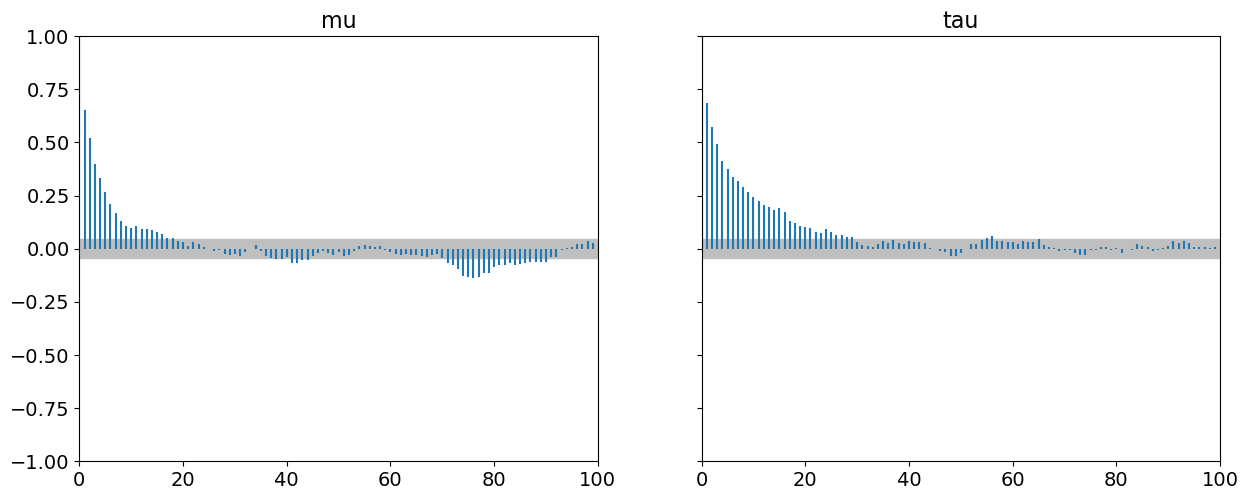

In [38]:
az.plot_autocorr(schools_trace, var_names=['mu', 'tau'], combined=True);

You can see very severe autocorrelation in `mu`, which is not surprising given the trace that we observed earlier.

The amount of correlation in an MCMC sample influences the **effective sample size** (ESS) of the sample. The ESS estimates how many *independent* draws contain the same amount of information as the *dependent* sample obtained by MCMC sampling.

Given a series of samples $x_j$, the empirical mean is

$$
\hat{\mu} = \frac{1}{n}\sum_{j=1}^n x_j
$$

and the variance of the estimate of the empirical mean is 

$$
\operatorname{Var}(\hat{\mu}) = \frac{\sigma^2}{n},
$$
where $\sigma^2$ is the true variance of the underlying distribution.

Then the effective sample size is defined as the denominator that makes this relationship still be true:

$$
\operatorname{Var}(\hat{\mu}) = \frac{\sigma^2}{n_{\text{eff}}}.
$$

The effective sample size is estimated using the partial sum:

$$\hat{n}_{eff} = \frac{mn}{1 + 2\sum_{i=1}^T \hat{\rho}_i}$$

where $T$ is the first odd integer such that $\hat{\rho}_{T+1} + \hat{\rho}_{T+2}$ is negative.

The issue here is related to the fact that we are **estimating** the effective sample size from the fit output. Values of $n_{eff} / n_{iter} < 0.001$ indicate a biased estimator, resulting in an overestimate of the true effective sample size.

Vehtari *et al* (2019) recommend an ESS of at least 400 to ensure reliable estimates of variances and autocorrelations. They also suggest running at least 4 chains before calculating any diagnostics.

Its important to note that ESS can vary across the quantiles of the MCMC chain being sampled. 

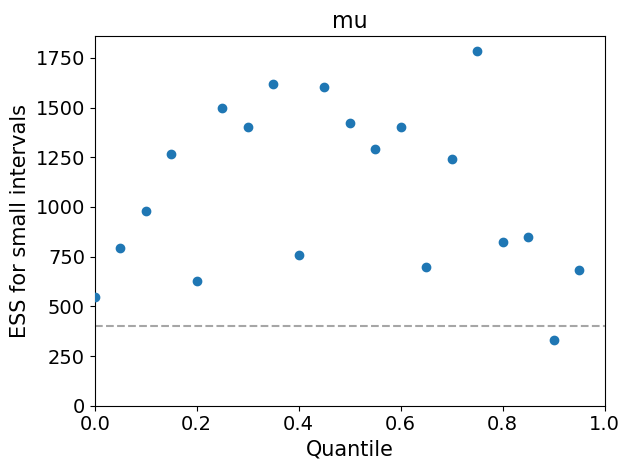

In [39]:
az.plot_ess(schools_trace, var_names=['mu'])
plt.tight_layout();

Using ArViZ, we can visualize the evolution of ESS as the MCMC sample accumulates. When the model is converging properly, both lines in this plot should be approximately linear.

The standard ESS estimate, which mainly assesses how well the centre of the distribution is resolved, is referred to as **bulk-ESS**. In order to estimate intervals reliably, it is also important to consider the **tail-ESS**.

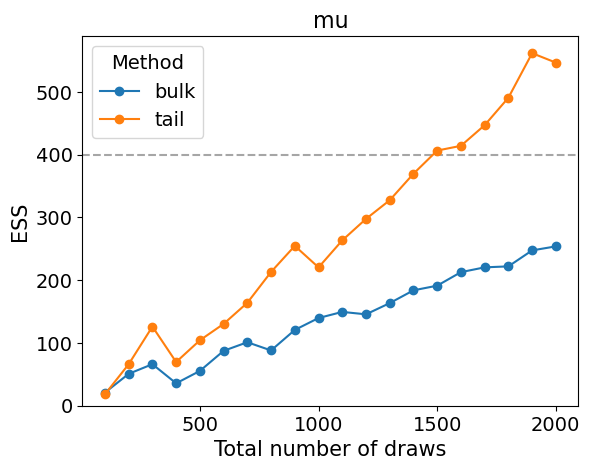

In [40]:
az.plot_ess(schools_trace, var_names=['mu'], kind='evolution');

ESS statistics can also be tabulated, by generating a `summary` of the parameters of interest.

In [41]:
az.summary(schools_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,7.473,4.352,-0.992,15.198,0.273,0.194,254.0,547.0,1.01
tau,3.633,3.030,0.170,9.203,0.256,0.182,108.0,173.0,1.05
theta[Choate],8.991,5.984,-2.001,20.347,0.329,0.233,313.0,589.0,1.02
theta[Deerfield],7.591,5.088,-1.651,17.210,0.273,0.193,333.0,652.0,1.01
theta[Phillips Andover],6.736,5.789,-4.458,17.289,0.308,0.218,330.0,676.0,1.01
theta[Phillips Exeter],7.398,5.222,-2.042,17.754,0.284,0.201,331.0,480.0,1.01
theta[Hotchkiss],6.082,5.267,-4.463,15.535,0.326,0.231,262.0,449.0,1.01
theta[Lawrenceville],6.687,5.552,-4.475,16.543,0.295,0.209,351.0,569.0,1.02
theta[St. Paul's],8.938,5.505,-1.629,18.896,0.307,0.217,312.0,545.0,1.01
theta[Mt. Hermon],7.641,5.767,-3.770,17.562,0.279,0.197,387.0,554.0,1.01


It is tempting to want to **thin** the chain to eliminate the autocorrelation (*e.g.* taking every 20th sample from traces with autocorrelation as high as 20), but this is a waste of time. Since thinning deliberately throws out the majority of the samples, no efficiency is gained; you ultimately require more samples to achive a particular desired sample size. 

## Bayesian Fraction of Missing Information

The Bayesian fraction of missing information (BFMI) is a measure of how hard it is to
sample level sets of the posterior at each iteration. Specifically, it quantifies **how well momentum resampling matches the marginal energy distribution**. 

$$\text{BFMI} = \frac{\mathbb{E}_{\pi}[\text{Var}_{\pi_{E|q}}(E|q)]}{\text{Var}_{\pi_{E}}(E)}$$

$$\widehat{\text{BFMI}} = \frac{\sum_{i=1}^N (E_n - E_{n-1})^2}{\sum_{i=1}^N (E_n - \bar{E})^2}$$

Here, $E|q$ is the energy induced by momentum resampling at position $q$.

A small value indicates that the adaptation phase of the sampler was unsuccessful, and invoking the central limit theorem may not be valid. It indicates whether the sampler is able to *efficiently* explore the posterior distribution.

Though there is not an established rule of thumb for an adequate threshold, values close to one are optimal. Reparameterizing the model is sometimes helpful for improving this statistic.

BFMI calculation is only available in samples that were simulated using HMC or NUTS.

In [42]:
az.bfmi(schools_trace)

array([0.20528262, 0.23263843, 0.21719391, 0.19291049])

Another way of diagnosting this phenomenon is by comparing the overall distribution of 
energy levels with the *change* of energy between successive samples. Ideally, they should be very similar.

If the distribution of energy transitions is narrow relative to the marginal energy distribution, this is a sign of inefficient sampling, as many transitions are required to completely explore the posterior. On the other hand, if the energy transition distribution is similar to that of the marginal energy, this is evidence of efficient sampling, resulting in near-independent samples from the posterior.

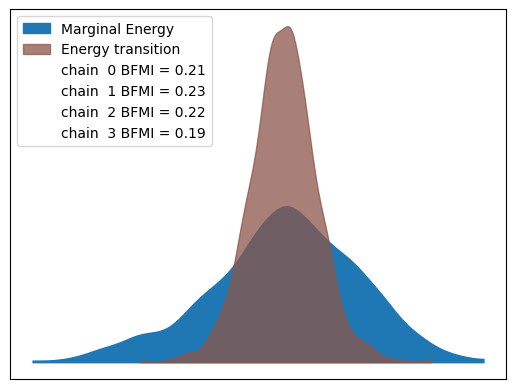

In [43]:
az.plot_energy(schools_trace);

In [44]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
s = np.array([15, 10, 16, 11, 9, 11, 10, 18])
schools = np.array(
    [
        "Choate",
        "Deerfield",
        "Phillips Andover",
        "Phillips Exeter",
        "Hotchkiss",
        "Lawrenceville",
        "St. Paul's",
        "Mt. Hermon",
    ]
)

with pm.Model(coords={'school': schools}) as schools_uncentered:
    
    mu = pm.Normal("mu", 0, sigma=1e6)
    tau = pm.HalfCauchy("tau", 5)

    z = pm.Normal('z', dims='school')
    theta = pm.Deterministic("theta", mu + tau*z, dims='school')

    obs = pm.Normal("obs", theta, sigma=s, observed=y)

    trace_uncentered = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: >

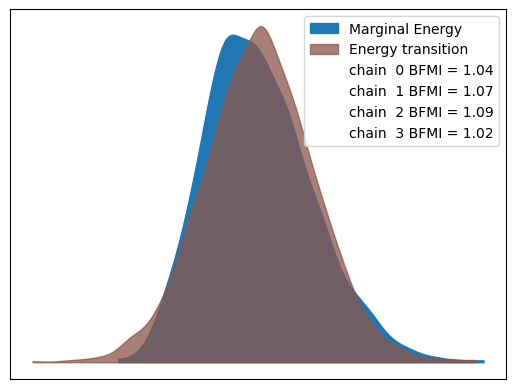

In [45]:
az.plot_energy(trace_uncentered)

## Goodness of Fit

As noted at the beginning of this section, convergence diagnostics are only the first step in the evaluation
of MCMC model outputs. It is possible for an entirely unsuitable model to converge, so additional steps are needed to ensure that the estimated model adequately fits the data. 

One intuitive way of evaluating model fit is to compare model predictions with the observations used to fit
the model. In other words, the fitted model can be used to simulate data, and the distribution of the simulated data should resemble the distribution of the actual data.

Fortunately, simulating data from the model is a natural component of the Bayesian modelling framework. Recall, from the discussion on prediction, the posterior predictive distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Here, $\tilde{y}$ represents some hypothetical new data that would be expected, taking into account the posterior uncertainty in the model parameters. 

Sampling from the posterior predictive distribution is easy in PyMC. The `sample_posterior_predictive` function draws posterior predictive samples from all of the observed variables in the model. Consider the PKU model, 
where IQ is modeled as a Gaussian random variable, which is thought to be influenced by blood Phe levels.

The posterior predictive distribution of deaths uses the same functional
form as the data likelihood, in this case a binomial stochastic. Here is
the corresponding sample from the posterior predictive distribution (we typically need very few samples relative to the MCMC sample):

In [46]:
with schools_uncentered:
    pm.sample_posterior_predictive(trace_uncentered, extend_inferencedata=True)

Sampling: [obs]


Output()

The degree to which simulated data correspond to observations can be evaluated visually. This allows for a qualitative comparison of model-based replicates and observations. If there is poor fit, the true value of the data may appear in the tails of the histogram of replicated data, while a good fit will tend to show the true data in high-probability regions of the posterior predictive distribution.

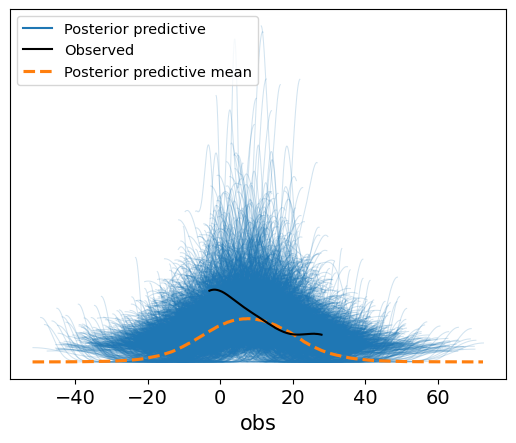

In [47]:
az.plot_ppc(trace_uncentered);

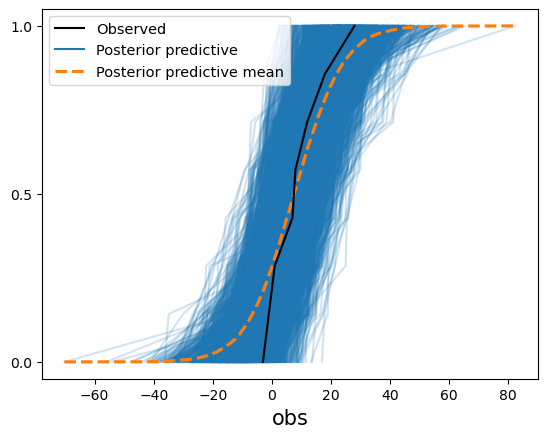

In [48]:
az.plot_ppc(schools_trace, kind='cumulative');

A quantitative approach is to calculate quantiles of each observed data point relative to the corresponding distribution of posterior-simulated values. For an adequate fit, there should not be severe peaks in the histogram near zero and one.

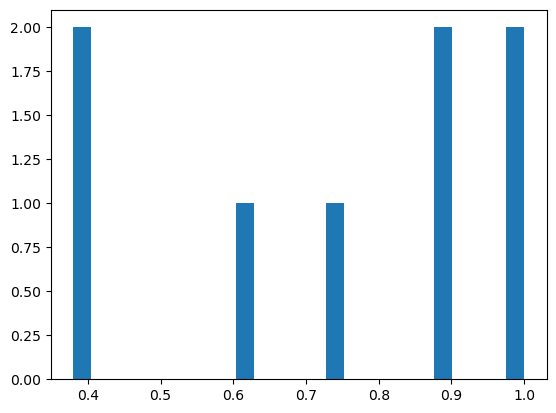

In [49]:
from scipy.stats import percentileofscore

plt.hist([np.round(percentileofscore(_x, _y)/100, 2) for _x,_y in zip(schools_trace.posterior_predictive['obs'].sel(chain=0), y)], bins=25);


---

## Reference

Gelman, A., & Rubin, D. B. (1992). Inference from iterative simulation using multiple sequences. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 457–472.

[Vehtari, Gelman, Simpson, Carpenter, Bürkner (2019)](https://arxiv.org/abs/1903.08008) Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC


[Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. Statistics and Computing, 24(6), 997–1016.](http://doi.org/10.1007/s11222-013-9416-2)
